In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_absolute_error
from keras.callbacks import History
from keras.callbacks import Callback

In [2]:
df = pd.read_csv('./Processed_Dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop(columns=['Xylene','Toluene','Benzene','NO','NO2'])
df['Datetime'] = pd.to_datetime(df['Datetime'])

df.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,60.50,98.00,18.25,8.50,0.1,11.85,126.40,95.59999
1,2017-11-24 18:00:00,65.50,111.25,15.07,9.77,0.1,13.17,117.12,95.59999
2,2017-11-24 19:00:00,80.00,132.00,15.15,12.02,0.1,12.08,98.98,95.59999
3,2017-11-24 20:00:00,81.50,133.25,10.23,11.58,0.1,10.47,112.20,95.59999
4,2017-11-24 21:00:00,75.25,116.00,10.43,12.03,0.1,9.12,106.35,95.59999


In [3]:
def create_sequence(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i + timesteps])
    return np.array(sequences)

In [4]:
X = df.drop(columns=['AQI','Datetime'])
y = df['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [5]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [6]:
# Callback untuk menyimpan R-squared dan MAE setiap epoch
class MetricsHistory(Callback):
    def on_train_begin(self, logs={}):
        self.r2_scores = []
        self.mae_scores = []

    def on_epoch_end(self, epoch, logs={}):
        X_val_lstm = X_test
        y_pred = self.model.predict(X_val_lstm)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        self.r2_scores.append(r2)
        self.mae_scores.append(mae)
        
        print(f'Epoch {epoch+1} - MAE: {mae:.6f}')

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)



Epoch 1/50

142/142 [==============================] - 1s 5ms/step
Epoch 1 - MAE: 35.624111
285/285 - 8s - loss: 87.7209 - 8s/epoch - 30ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 22.274283
285/285 - 5s - loss: 67.6006 - 5s/epoch - 16ms/step
Epoch 3/50
142/142 [==============================] - 1s 6ms/step
Epoch 3 - MAE: 18.057400
285/285 - 5s - loss: 54.4125 - 5s/epoch - 16ms/step
Epoch 4/50
142/142 [==============================] - 1s 6ms/step
Epoch 4 - MAE: 14.039159
285/285 - 5s - loss: 44.6755 - 5s/epoch - 17ms/step
Epoch 5/50
142/142 [==============================] - 1s 7ms/step
Epoch 5 - MAE: 11.092358
285/285 - 5s - loss: 36.5383 - 5s/epoch - 18ms/step
Epoch 6/50
142/142 [==============================] - 1s 6ms/step
Epoch 6 - MAE: 11.634312
285/285 - 5s - loss: 31.1266 - 5s/epoch - 17ms/step
Epoch 7/50
142/142 [==============================] - 1s 6ms/step
Epoch 7 - MAE: 9.320006
285/285 - 5s - loss: 27.9576 - 5s/epoch - 16ms/st

In [8]:
standardscalerdf = df
standardscalerdf['Datetime'] = pd.to_datetime(standardscalerdf['Datetime'])

datetime = standardscalerdf[['Datetime']]
aqi = standardscalerdf[['AQI']]

standardscalerdf = standardscalerdf.drop(columns=['Datetime','AQI'])

standardscalerdf.head()

,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,60.50,98.00,18.25,8.50,0.1,11.85,126.40
1,65.50,111.25,15.07,9.77,0.1,13.17,117.12
2,80.00,132.00,15.15,12.02,0.1,12.08,98.98
3,81.50,133.25,10.23,11.58,0.1,10.47,112.20
4,75.25,116.00,10.43,12.03,0.1,9.12,106.35


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(standardscalerdf)

# Konversi scaled_data kembali menjadi DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=standardscalerdf.columns)

# Gabungkan scaled_df dengan date_column
result_df = pd.concat([datetime, scaled_df, aqi], axis=1)

standardscalerdf = result_df

standardscalerdf.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,0.798129,0.454830,0.196889,-0.584394,-1.076443,-0.190467,3.506879,95.59999
1,2017-11-24 18:00:00,0.979525,0.742129,-0.009747,-0.377389,-1.076443,-0.078478,3.138017,95.59999
2,2017-11-24 19:00:00,1.505572,1.192050,-0.004549,-0.010648,-1.076443,-0.170954,2.416987,95.59999
3,2017-11-24 20:00:00,1.559990,1.219154,-0.324250,-0.082366,-1.076443,-0.307546,2.942456,95.59999
4,2017-11-24 21:00:00,1.333246,0.845123,-0.311254,-0.009018,-1.076443,-0.422080,2.709930,95.59999


In [10]:
X = standardscalerdf.drop(columns=['AQI','Datetime'])
y = standardscalerdf['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [11]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback2 = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback2])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 1s 4ms/step
Epoch 1 - MAE: 32.823062
285/285 - 8s - loss: 85.0023 - 8s/epoch - 27ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 21.259615
285/285 - 4s - loss: 65.0667 - 4s/epoch - 14ms/step
Epoch 3/50
142/142 [==============================] - 1s 5ms/step
Epoch 3 - MAE: 20.756942
285/285 - 4s - loss: 52.8070 - 4s/epoch - 16ms/step
Epoch 4/50
142/142 [==============================] - 1s 6ms/step
Epoch 4 - MAE: 42.192469
285/285 - 4s - loss: 46.4940 - 4s/epoch - 15ms/step
Epoch 5/50
142/142 [==============================] - 1s 6ms/step
Epoch 5 - MAE: 18.494258
285/285 - 4s - loss: 41.4159 - 4s/epoch - 16ms/step
Epoch 6/50
142/142 [==============================] - 1s 5ms/step
Epoch 6 - MAE: 11.689074
285/285 - 4s - loss: 31.3369 - 4s/epoch - 15ms/step
Epoch 7/50
142/142 [==============================] - 1s 5ms/step
Epoch 7 - MAE: 10.778146
285/285 - 4s - loss: 27.3742 - 4s/epoch - 15ms/step

In [13]:
minmaxdf = df
minmaxdf['Datetime'] = pd.to_datetime(minmaxdf['Datetime'])

datetime = minmaxdf[['Datetime']]
aqi = minmaxdf[['AQI']]

minmaxdf = minmaxdf.drop(columns=['Datetime','AQI'])

minmaxdf.head()

,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,60.50,98.00,18.25,8.50,0.1,11.85,126.40
1,65.50,111.25,15.07,9.77,0.1,13.17,117.12
2,80.00,132.00,15.15,12.02,0.1,12.08,98.98
3,81.50,133.25,10.23,11.58,0.1,10.47,112.20
4,75.25,116.00,10.43,12.03,0.1,9.12,106.35


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(minmaxdf)

# Konversi scaled_data kembali menjadi DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=minmaxdf.columns)

# Gabungkan scaled_df dengan date_column
result_df = pd.concat([datetime, scaled_df, aqi], axis=1)

minmaxdf = result_df

minmaxdf.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,0.195300,0.173757,0.056748,0.042452,0.010081,0.060625,0.631146,95.59999
1,2017-11-24 18:00:00,0.211507,0.197492,0.046859,0.048870,0.010081,0.067395,0.584588,95.59999
2,2017-11-24 19:00:00,0.258509,0.234662,0.047108,0.060242,0.010081,0.061804,0.493578,95.59999
3,2017-11-24 20:00:00,0.263371,0.236901,0.031810,0.058018,0.010081,0.053547,0.559904,95.59999
4,2017-11-24 21:00:00,0.243112,0.206001,0.032432,0.060292,0.010081,0.046623,0.530554,95.59999


In [15]:
X = minmaxdf.drop(columns=['AQI','Datetime'])
y = minmaxdf['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [16]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback3 = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback3])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 2s 6ms/step
Epoch 1 - MAE: 34.918860
285/285 - 11s - loss: 86.2703 - 11s/epoch - 40ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 21.840508
285/285 - 4s - loss: 66.7714 - 4s/epoch - 15ms/step
Epoch 3/50
142/142 [==============================] - 1s 5ms/step
Epoch 3 - MAE: 20.449399
285/285 - 5s - loss: 53.8274 - 5s/epoch - 16ms/step
Epoch 4/50
142/142 [==============================] - 1s 5ms/step
Epoch 4 - MAE: 24.489904
285/285 - 5s - loss: 46.4891 - 5s/epoch - 16ms/step
Epoch 5/50
142/142 [==============================] - 1s 6ms/step
Epoch 5 - MAE: 29.750792
285/285 - 5s - loss: 42.2601 - 5s/epoch - 18ms/step
Epoch 6/50
142/142 [==============================] - 1s 7ms/step
Epoch 6 - MAE: 34.552077
285/285 - 5s - loss: 40.0045 - 5s/epoch - 19ms/step
Epoch 7/50
142/142 [==============================] - 1s 7ms/step
Epoch 7 - MAE: 38.576700
285/285 - 5s - loss: 38.7878 - 5s/epoch - 19ms/st

In [18]:
robustdf = df
robustdf['Datetime'] = pd.to_datetime(robustdf['Datetime'])

datetime = robustdf[['Datetime']]
aqi = robustdf[['AQI']]

robustdf = robustdf.drop(columns=['Datetime','AQI'])

robustdf.head()

,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,60.50,98.00,18.25,8.50,0.1,11.85,126.40
1,65.50,111.25,15.07,9.77,0.1,13.17,117.12
2,80.00,132.00,15.15,12.02,0.1,12.08,98.98
3,81.50,133.25,10.23,11.58,0.1,10.47,112.20
4,75.25,116.00,10.43,12.03,0.1,9.12,106.35


In [19]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaled_data = scaler.fit_transform(robustdf)

# Konversi scaled_data kembali menjadi DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=robustdf.columns)

# Gabungkan scaled_df dengan date_column
result_df = pd.concat([datetime, scaled_df, aqi], axis=1)

robustdf = result_df

robustdf.head()

,Datetime,PM2.5,PM10,NOx,NH3,CO,SO2,O3,AQI
0,2017-11-24 17:00:00,0.847458,0.414605,0.807467,-0.491140,-1.787933,-0.216058,3.626932,95.59999
1,2017-11-24 18:00:00,1.016949,0.664311,0.436406,-0.317168,-1.787933,-0.023358,3.249390,95.59999
2,2017-11-24 19:00:00,1.508475,1.055359,0.445741,-0.008949,-1.787933,-0.182482,2.511391,95.59999
3,2017-11-24 20:00:00,1.559322,1.078916,-0.128355,-0.069223,-1.787933,-0.417518,3.049227,95.59999
4,2017-11-24 21:00:00,1.347458,0.753828,-0.105017,-0.007579,-1.787933,-0.614599,2.811229,95.59999


In [20]:
X = robustdf.drop(columns=['AQI','Datetime'])
y = robustdf['AQI']

# Hitung jumlah sampel untuk data latih (80%) dan data uji (20%)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Bagi data menjadi data latih dan data uji berdasarkan jumlah sampel yang dihitung
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [21]:
# Mengubah data menjadi urutan dengan panjang 48 timestep
X_train = create_sequence(X_train, 24)
X_test  = create_sequence(X_test, 24)

# Menyesuaikan panjang y_train dan y_test
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18204, 24, 7)
X_test shape: (4534, 24, 7)
y_train shape: (18204,)
y_test shape: (4534,)


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.metrics import r2_score, mean_absolute_error

# Inisialisasi model Sequential
model_lstm = Sequential()

# Tambahkan lapisan LSTM dengan 50 unit dan input_shape=(1, jumlah_fitur)
model_lstm.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[-1]), return_sequences=False))

# Tambahkan lapisan Dense dengan 1 neuron (untuk output regresi)
model_lstm.add(Dense(1))

# Kompilasi model dengan mean squared error sebagai loss function dan optimizer adam
model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Inisialisasi callback untuk menyimpan R-squared
callback4 = MetricsHistory()

# Latih model menggunakan data latih dengan callback R2History
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[callback4])

# Prediksi menggunakan data uji
y_pred_lstm = model_lstm.predict(X_test)

Epoch 1/50
142/142 [==============================] - 2s 5ms/step
Epoch 1 - MAE: 31.432735
285/285 - 11s - loss: 83.5703 - 11s/epoch - 39ms/step
Epoch 2/50
142/142 [==============================] - 1s 5ms/step
Epoch 2 - MAE: 20.885399
285/285 - 4s - loss: 63.8065 - 4s/epoch - 14ms/step
Epoch 3/50
142/142 [==============================] - 1s 5ms/step
Epoch 3 - MAE: 21.020666
285/285 - 4s - loss: 51.9960 - 4s/epoch - 14ms/step
Epoch 4/50
142/142 [==============================] - 1s 7ms/step
Epoch 4 - MAE: 13.813087
285/285 - 5s - loss: 44.6034 - 5s/epoch - 17ms/step
Epoch 5/50
142/142 [==============================] - 1s 6ms/step
Epoch 5 - MAE: 13.237863
285/285 - 5s - loss: 34.7172 - 5s/epoch - 16ms/step
Epoch 6/50
142/142 [==============================] - 1s 6ms/step
Epoch 6 - MAE: 13.479699
285/285 - 5s - loss: 28.7560 - 5s/epoch - 17ms/step
Epoch 7/50
142/142 [==============================] - 1s 6ms/step
Epoch 7 - MAE: 10.876128
285/285 - 5s - loss: 26.3485 - 5s/epoch - 16ms/st

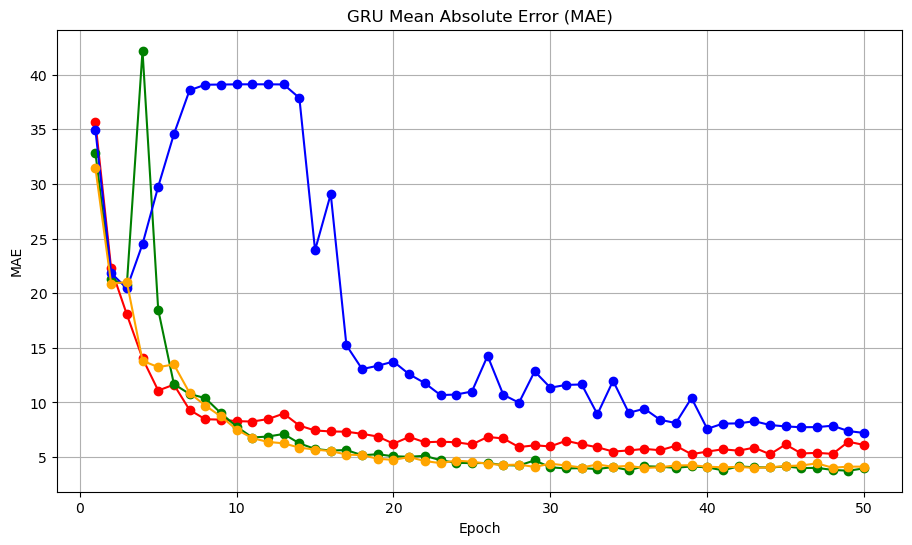

In [23]:
# Plot R-squared per epoch
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 51), callback.mae_scores, marker='o', linestyle='-', color='r', label='Raw')
plt.plot(np.arange(1, 51), callback2.mae_scores, marker='o', linestyle='-', color='g', label='StandardScaler')
plt.plot(np.arange(1, 51), callback3.mae_scores, marker='o', linestyle='-', color='b', label='MinMaxScaler')
plt.plot(np.arange(1, 51), callback4.mae_scores, marker='o', linestyle='-', color='orange', label='RobustScaler')
plt.title('GRU Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.legend()

plt.show()